Filtrado de spam en mensajes de texto (SMS)
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/machine-learning/blob/master/01-archivos-y-directorios.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/machine-learning/blob/master/01-archivos-y-directorios.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/machine-learning/blob/master/LICENCIA.txt)  
[Readme](https://github.com/jdvelasq/machine-learning/blob/master/readme.md)

# Definición del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.   

# Definición del problema en términos de los datos

La muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). El problema en términos de los datos consiste en clasificar si un un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

# Exploración

In [2]:
# carga de los datos
sms_raw <- read.csv("data/sms_spam.csv", stringsAsFactors = FALSE)

In [3]:
# verificación de los datos cargados
str(sms_raw)

'data.frame':	5574 obs. of  2 variables:
 $ type: chr  "ham" "ham" "spam" "ham" ...
 $ text: chr  "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..." "Ok lar... Joking wif u oni..." "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question("| __truncated__ "U dun say so early hor... U c already then say..." ...


In [5]:
# se convierte la columna type, que contiene strings, en un factor
sms_raw$type <- factor(sms_raw$type)
str(sms_raw$type)

 Factor w/ 2 levels "ham","spam": 1 1 2 1 1 2 1 1 2 2 ...


In [6]:
# cantidad de casos para cada tipo de mensaje
table(sms_raw$type)


 ham spam 
4827  747 

In [7]:
# se convierte el conteo en probabilidades
round(prop.table(table(sms_raw$type)) * 100, digits = 1)


 ham spam 
86.6 13.4 

# Naive Bayes

Para este problema en particular se desea calcular la probabilidad de que un mensaje sea valido y la probabilidad de que sea spam a partir de las palabras que contiene. En esta sección se explica una metodología para calcular dicha probabilidad.

**Definición de probabilidad como frecuencia.** En su forma más simple, el concepto de probabilidad puede interpretarse como la frecuencia con que ocurre un evento. Ejemplo: Tirada de dos dados:

![alt text](images/tirada-dados.jpg)

    Prob(𝑋= 2) = 1 / 36 
    Prob(𝑋= 3) = 2 / 36  
    Prob(𝑋= 4) = 3 / 36
    Prob(𝑋= 5) = 4 / 36 
    Prob(𝑋= 6) = 5 / 36 
    Prob(𝑋= 7) = 6 / 36
    Prob(𝑋= 8) = 5 / 36 
    Prob(𝑋= 9) = 4 / 36 
    Prob(𝑋=10) = 3 / 36
    Prob(𝑋=11) = 2 / 36 
    Prob(𝑋=12) = 1 / 36 

**Ejercicio.--** Los soldados mediavales apostaban con dos dados de la siguiente manera: si el resultado es par {2, 4, 6, 8, 10, 12} ganaba el soldado A; y si el resultado es impar {3, 5, 7, 9, 11} ganaba el soldado B. ¿Quién tiene mayor probabilidad de ganar?

**Definiciones básicas.** 

* Todas las probabilidades deben estar entre 0 y 1: 
$$0 <= \text{Prob}(x_i) <= 1$$

* Las probabilidades de eventos mutuamente exclusivos y colectivamente exhaustivos deben sumar la unidad:

$$\sum_{i=1}^n \text{Prob}(x_i) = 1$$

<img src="images/eventos-conjuntos-2.jpg" width=500>

$$\text{Prob}(F1) + \text{Prob}(F2) + \text{Prob}(F3) = 1$$ 

$$\text{Prob}(V1) + \text{Prob}(V2) = 1$$ 

**Probabilidad conjunta.** Los eventos ocurren simultaneamente. 

$$\text{Prob}(F1~\text{and}~V2)$$

<img src="images/probabilidad-conjunta-3.jpg" width=250>

* Probabilidad condicional: probabilidad de que ocurra un evento sabiendo que el otro ya ocurrio.

$$\text{Prob}(V2 ~ | ~F1) = \text{Prob}(F1~\text{and} ~ V2) ~/~\text{Prob}(F1)$$

<img src="images/probabilidad-condicional.jpg" width=150>

* Independencia: Si los eventos $A$ y $B$ son independientes:

$$\text{Prob}(A~|~B) = \text{Prob}(A)$$

De la definición de probabilidad condicional:

$$\text{Prob}(A~|~B) = \text{Prob}(A) = \frac{\text{Prob}(A~\text{and}~B)}{\text{Prob}(B)}$$

Entonces:

$$\text{Prob}(A~\text{and}~B)~=~\text{Prob}(A)~*~\text{Prob}(B)$$ 

* Probabilidad marginal: Sea $𝑋_i$ con $𝑖 = 1, ... , 𝑛$, un conjunto de eventos mutuamente exclusivos y colectivamente exhaustivos. La probabilidad de un evento $𝐴$ es:

$$\text{Prob}(A) = \sum_{i=1}^n \text{Prob}(A~\text{and}~X_i)$$

<img src="images/eventos-conjuntos.jpg" width=750>

* Para dos eventos $A$ y $B$:

$$\text{Prob}(A ~\text{or}~B) = \text{Prob}(A) + \text{Prob}(B) - \text{Prob}(A~\text{and}~B)$$

<img src="images/probabilidad-conjunta-3.jpg" width=250>

* Complemento: 
$$\text{Prob}(\text{not}~ A) = 1 - \text{Prob}(A)$$

* Probabilidad total: 
$$\text{Prob}(A) = \text{Prob}(A~\text{and}~B) + \text{Prob}(A~\text{and}~\text{not}~B) = 
\text{Prob}(A~|~B)~\text{Prob}(B) ~+~ \text{Prob}(A~|~\text{not}~B)~\text{Prob}(\text{not}~B)$$

* Teorema de Bayes:
$$\text{Prob}(A~\text{and}~B) = \text{Prob}(A~|~B)~\text{Prob}({B}) =  \text{Prob}(B~|~A)~\text{Prob}({A})$$

$$\text{Prob}(B~|~A) = \frac{\text{Prob}(A~|~B)~\text{Prob}(B)}{\text{Prob}(A)}$$

$$ = \frac{\text{Prob}(A~|~B)~\text{Prob}(B)} {\text{Prob}(A~|~B)~\text{Prob}(B) ~+~ \text{Prob}(A~|~\text{not}~B)~\text{Prob}(\text{not}~B)}$$

---
**Ejercicio.--** Complete las siguientes tablas de probabilidades:



*Probabilidades totales*:

                F1     F2     F3  Prob(V)
    ---------------------------------------
         V1   0.10      ?   0.03        ?
         V2      ?   0.26   0.14     0.62
    ---------------------------------------
    Prob(F)      ?      ?      ?      
    
    

*Probabilidades condicionales*:

    Prob(F|V)                           Prob(V|F)

                F1     F2     F3                    F1     F2     F3  
    ----------------------------        ----------------------------
         V1  10/38      ?      ?             V1      ?  25/37      ?        
         V2      ?      ?  14/62             V2      ?      ?      ?  
         

---

En términos del problema de filtrado de mensajes de texto, V1 se interpreta como "Es spam" y V2 como NOT "Es spam", ya que son eventos mutuamente exclusivos y colectivamente exhaustivos. Si F es la ocurrencia de una determinada palabra en el texto, como por ejemplo "Viagra", entonces F1 sería "Viagra"("viagra" aparece en el mensaje) y F2 sería NOT "Viagra" ("viagra" no aparece en el mensaje).   

De acuerdo con el teorema de Bayes:

$$\text{Prob}(\text{spam}~|~\text{viagra}) = \frac{\text{Prob}(\text{viagra}~|~
\text{spam})*\text{Prob}(\text{spam})}{\text{Prob}(\text{viagra})}$$

* $\text{Prob}(\text{spam}~|~\text{viagra})$ es la probabilidad posterior.
* $\text{Prob}(\text{viagra}~|~\text{spam})$ es la verosimilitud.
* $\text{Prob}(\text{spam})$ es la probabilidad prior, es decir, la probabilidad de que un mensaje sea spam sin conocer el texto que contiene.
* $\text{Prob}(\text{viagra})$ es la verosimilitud marginal.

El cálculo de cada una de las probabilidades se realiza tal como se hizo en el ejercicio anterior.

**Ejercicio.--** Verifique las dos tablas de probabilidades condicionales calculadas en el ejercicio anterior usando el teorema de Bayes.

**Algoritmo Naive Bayes.** Se tiene una muestra de ejemplos de mensajes que han sido catalogados como spam y válidos (no spam). Para realizar la clasificación se tienen cuatro palabras $w_1$, $w_2$, $w_3$ y $w_4$ que pueden estar o no en cada uno de los mensajes de texto. La probabilidad de que la palabra $w_1$ este en el mensaje se nota como $\text{Prob}(w_1)$, y de que no este como $\text{Prob}(\text{not }w_1)$.

Si se recibe un mensaje que contiene las palabras $w_1$ y $w_4$ y no contiene las palabras $w_2$ y $w_3$, la probabilidad de que sea spam es:

$$\text{Prob}(\text{spam}~|~w_1~\text{and}~\text{not}~w_2~\text{and}~\text{not}~w_3~\text{and}~w_4) = 
\frac{\text{Prob}(w_1~\text{and}~\text{not}~w_2~\text{and}~\text{not}~w_3~\text{and}~w_4 |~\text{spam}) * \text{Prob}(\text{spam})}
{\text{Prob}(~w_1~\text{and}~\text{not}~w_2~\text{and}~\text{not}~w_3~\text{and}~w_4)}
$$

Si se tiene en cuenta que la ocurrencia de la palabras $w_1$, $w_2$, $w_3$ y $w_4$ son eventos independientes, es decir, que la ocurrencia de una palabra es independiente de la ocurrencia de la otra, entonces:

$$\text{Prob}(w_1~\text{and}~\text{not}~w_2~\text{and}~\text{not}~w_3~\text{and}~w_4 |~spam) \propto 
\text{Prob}(w_1~|~\text{spam})*
\text{Prob}(\text{not}~w_2~|~\text{spam})*
\text{Prob}(\text{not}~w_3|~\text{spam})*
\text{Prob}(w_4~|~\text{spam})$$

La ecuación anterior es la usada en la implementación computacional del algoritmo Naive Bayes para el cómputo de las probabilidades posteriores. En general, la ecuación anterior se puede escribir como:

$$\text{Prob}(C_L~|~F_1, ...,F_n) = \frac{1}{Z}\text{Prob}(C_L)\prod_{i=1}^n \text{Prob}(F_i~|~C_L)$$

donde:
* $F_i$ son las características.
* $1/Z$ es un factor de escala.
* $C_L$ representa el nivel $L$ de la clase $C$.

**Estimador de Laplace**. Al construir la tabla de probabilidades de las ocurrencias de las palabras, es posible que una palabra $w_k$ aparezca únicamente en los mensajes válidos y no aparezca en los mensajes spam. De esta forma si se calcula la probabilidad posterior de un nuevo mensaje que no la contiene , el resultado es cero para spam y uno para válido. Para prevernir esta situación, se hace que el conteo inicial no arranque en cero con el fin de que la probabilidad de ocurrencia sea siempre mayor que cero.

# Preparación de los datos

In [20]:
# El paquete tm se usa para minería de texto
# install.packages("tm")
# install.packages("NLP")
# install.packages("SnowballC")
library(tm)
library(SnowballC)

In [21]:
# se crea un corpus que es una colección de documentos
sms_corpus <- VCorpus(VectorSource(sms_raw$text))
print(sms_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5574


In [22]:
# se pueden seleccionar elementos particulares dentro del corpus
inspect(sms_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 111

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 29



In [23]:
# para ver un mensaje de texto en particular se usa as.character
as.character(sms_corpus[[1]])

[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

In [24]:
# para ver varios documentos se usa lapply
lapply(sms_corpus[1:2], as.character)

$`1`
[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

$`2`
[1] "Ok lar... Joking wif u oni..."

In [25]:
# se convierten todas las letras en minúsculas
sms_corpus_clean <- tm_map(sms_corpus, 
                           content_transformer(tolower))

# se eliminan los números
sms_corpus_clean <- tm_map(sms_corpus_clean, 
                           removeNumbers)

# se eliminan las stop-words
sms_corpus_clean <- tm_map(sms_corpus_clean,
                           removeWords, # funcion que remueve las palabras
                           stopwords()) # lista de palabras a remover

# se remueve la puntuación
sms_corpus_clean <- tm_map(sms_corpus_clean, 
                           removePunctuation)

# transforma a infinitivo las conjugaciones
sms_corpus_clean <- tm_map(sms_corpus_clean, 
                           stemDocument)

# se remueven espacios en blanco adicionales
sms_corpus_clean <- tm_map(sms_corpus_clean, 
                           stripWhitespace)

In [27]:
# mensajes antes de realizar la limpieza
lapply(sms_corpus[1:3], as.character)

$`1`
[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

$`2`
[1] "Ok lar... Joking wif u oni..."

$`3`
[1] "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [29]:
# mensajes despues de limpiar
lapply(sms_corpus_clean[1:3], as.character)

$`1`
[1] "go jurong point crazi avail bugi n great world la e buffet cine got amor wat"

$`2`
[1] "ok lar joke wif u oni"

$`3`
[1] "free entri wkli comp win fa cup final tkts st may text fa receiv entri questionstd txt ratetc appli s"

In [32]:
# se crea la matriz de términos del documento
sms_dtm <- DocumentTermMatrix(sms_corpus_clean)

In [33]:
# es posible crear la matriz de términos del documento
# sin pasar por el preprocesmiento previo y realizarlo
# directamente en la llamada a la función
sms_dtm2 <- 
DocumentTermMatrix(sms_corpus, 
                   control = list(tolower = TRUE, 
                                  removeNumbers = TRUE,
                                  stopwords = TRUE, 
                                  removePunctuation = TRUE,
                                  stemming = TRUE))

In [34]:
sms_dtm

<<DocumentTermMatrix (documents: 5574, terms: 6592)>>
Non-/sparse entries: 42608/36701200
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [35]:
sms_dtm2

<<DocumentTermMatrix (documents: 5574, terms: 6995)>>
Non-/sparse entries: 43713/38946417
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [37]:
# creación de los conjuntos de entrenamiento y prueba
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test  <- sms_dtm[4170:5559, ]
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels  <- sms_raw[4170:5559, ]$type

In [38]:
# distribución de los datos en el conjunto de entrenamiento
prop.table(table(sms_train_labels))

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

In [39]:
# distribución de los datos en el conjunto de prueba
prop.table(table(sms_test_labels))

sms_test_labels
      ham      spam 
0.8697842 0.1302158 

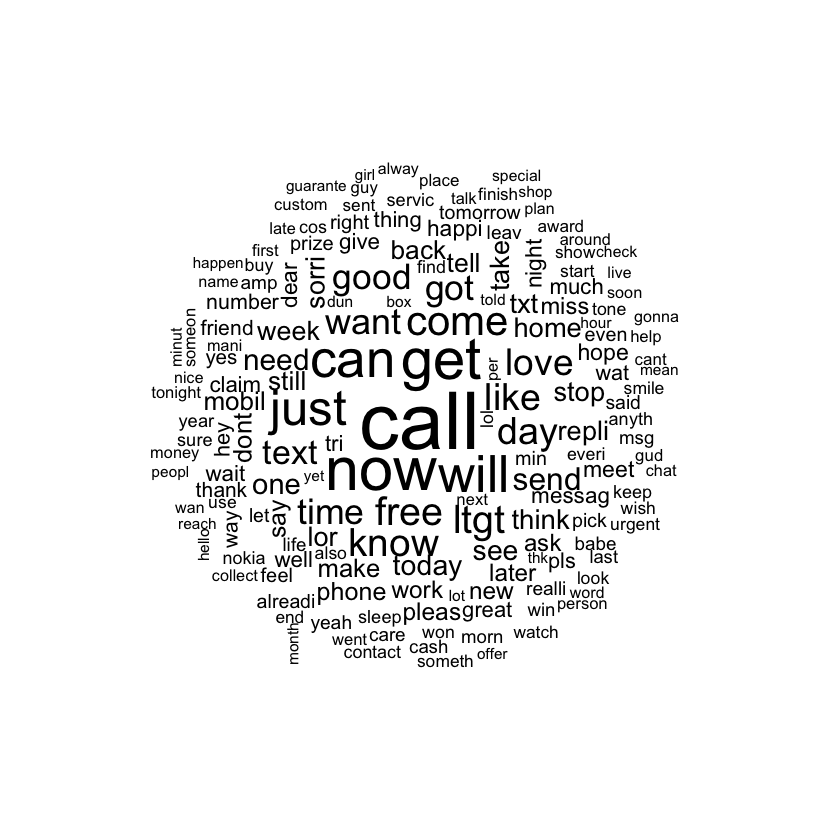

In [43]:
# en este caso es más útil visualizar 
# una nube que indique la frecuencia de las
# palabras
# install.packages("wordcloud")
# install.packages("RColorBrewer")
library(RColorBrewer)
library(wordcloud)
wordcloud(sms_corpus_clean, 
          min.freq = 50,         # número de veces que debe aparecer una palabra
          random.order = FALSE)  # palabras más frecuentes en el centro

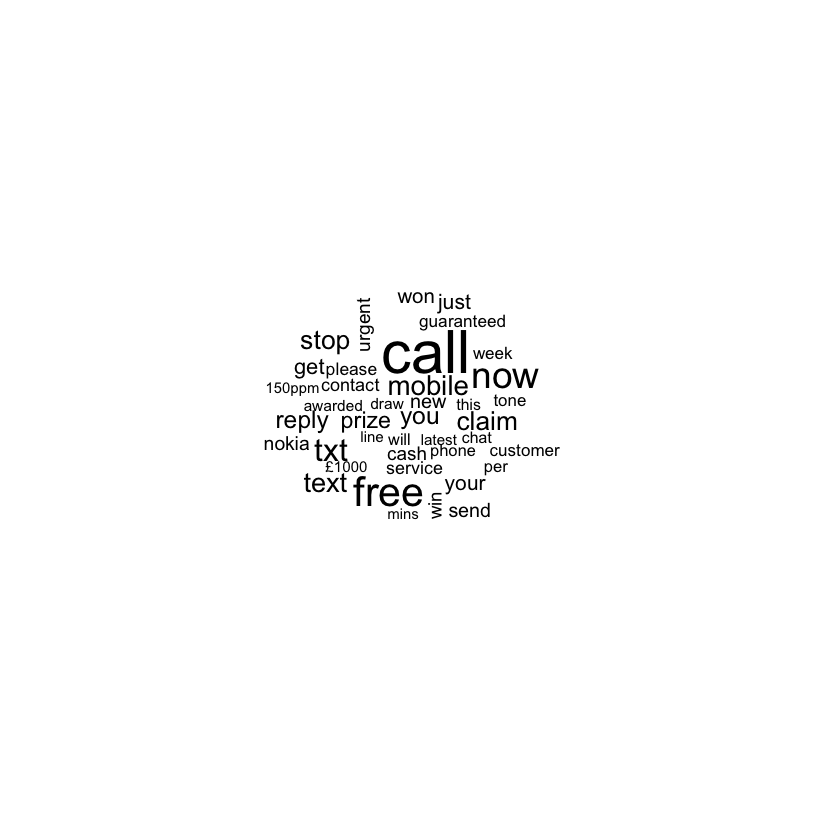

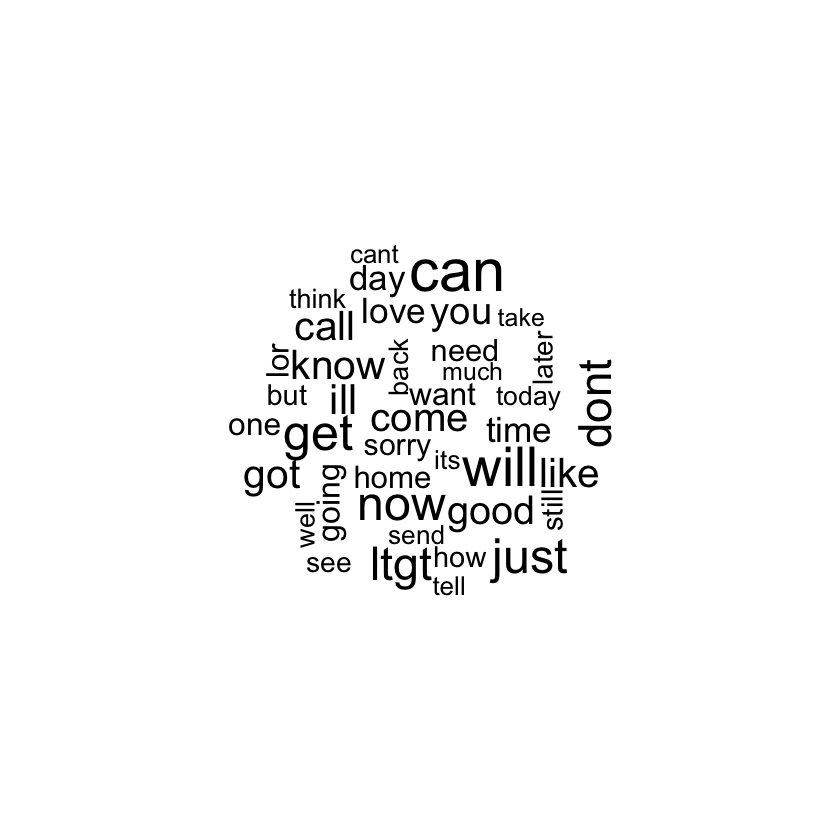

In [44]:
# palabras que más aparecen en mensajes spam y validos
spam <- subset(sms_raw, type == "spam")
ham <- subset(sms_raw, type == "ham")
wordcloud(spam$text, max.words = 40, scale = c(3, 0.5))
wordcloud(ham$text, max.words = 40, scale = c(3, 0.5))

In [45]:
# palabras que aparecen al menos en 5 mensajes
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)
str(sms_freq_words)

 chr [1:1157] "£wk" "abiola" "abl" "abt" "accept" "access" "account" ...


In [46]:
# se construyen conjuntos de entrenamiento y prueba 
# con las palabras que aparecen al menos en 5 mensajes
sms_dtm_freq_train<- sms_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- sms_dtm_test[ , sms_freq_words]

In [50]:
# se convierte la frecuencia de ocurrencia a "YES" y "No"
convert_counts <- 
function(x) {
    x <- ifelse(x > 0, "Yes", "No")
}
#
sms_train <- apply(sms_dtm_freq_train, 
                   MARGIN = 2,
                   convert_counts)
#
sms_test <- apply(sms_dtm_freq_test, 
                  MARGIN = 2,
                  convert_counts)

# Entrenamiento del modelo

In [51]:
# carga la librería
# install.packages("e1071")
library(e1071)
sms_classifier <- naiveBayes(sms_train, 
                             sms_train_labels)

# Evaluación del modelo

In [52]:
# se pronostica para los datos de prueba
sms_test_pred <- predict(sms_classifier, sms_test)

In [54]:
# install.packages("gmodels")
library(gmodels)
CrossTable(sms_test_pred, 
           sms_test_labels,
           prop.chisq = FALSE, 
           prop.t = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1200 |        20 |      1220 | 
             |     0.984 |     0.016 |     0.878 | 
             |     0.993 |     0.110 |           | 
-------------|-----------|-----------|-----------|
        spam |         9 |       161 |       170 | 
             |     0.053 |     0.947 |     0.122 | 
             |     0.007 |     0.890 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1209 |       181 |      1390 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


# Mejora del modelo

**Ejercicio.** Si en la construcción del clasificador se hace `laplace = 1`, en cuanto mejora la precisión del modelo. 